In [3]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
import scipy.signal as signal
import numpy as np

from IPython.display import Audio, display, HTML
from ipywidgets import interact

from scipy.io import wavfile
import requests
from io import BytesIO

%matplotlib inline
matplotlib.rcParams['animation.writer'] = 'avconv'
matplotlib.rcParams['figure.figsize'] = "8,3"

# workaround function for strange interact implementation
def showInInteract():
    import inspect
    for i in range(5):
        if 'interaction.py' in inspect.stack()[i][1]: plt.show()

# The Fourier Series and Harmonic Approximation

In this article, we will walk through the origins of the Fourier transform: the **Fourier Series**. The Fourier series takes a periodic signal $x(t)$ and describes it as a sum of sine and cosine waves. Noting that sine and cosine are themselves periodic functions, it becomes clear that $x(t)$ is also a periodic function. 

Mathematically, the Fourier series is described as follows. Let $x(t)$ be a periodic function with period $T$, i.e.

$$x(t)=x(t+nT), n\in\mathbb{Z}.$$ 

Then, we can write $x(t)$ as a Fourier series by

$$x(t)=\frac{a_0}{2}+\sum_{n=1}^{\infty}a_n\cos(2\pi \frac{nt}{T})+b_n\sin(2\pi\frac{nt}{T}),$$

where $a_n$ and $b_n$ are the coefficients of the Fourier series. They can be calculated by
$$\begin{align}a_n&=\frac{2}{T}\int_0^Tx(t)\cos(2\pi \frac{nt}{T})dt\\
b_n&=\frac{2}{T}\int_0^Tx(t)\sin(2\pi \frac{nt}{T})dt\end{align}.$$

Note that for a function with period $T$, the frequencies of the sines and cosines are $\frac{1}{T}, \frac{2}{T}, \frac{3}{T}, \dots$, i.e. they are multiples of the fundamental frequency $\frac{1}{T}$, which is the inverse period duration of the function. Therefore the frequency $\frac{n}{T}$ is called the $n$th *harmonic*. The name *harmonic* stems from the fact for the human ear frequencies with integer ratios sound "nice", and the frequencies are all integer multiples of the fundamental frequency.

Let us verify the calculation of the Fourier coefficients and the function reconstruction numerically. First, we define some functions with period $T=1$ that we want to expand into a Fourier series:

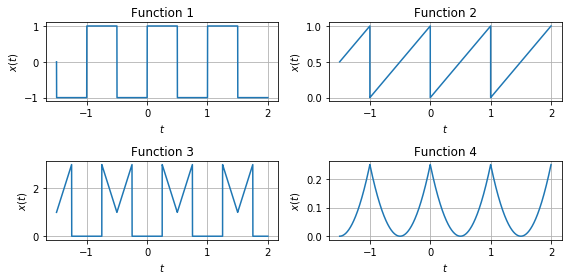

In [4]:
Fs = 10000
func1 = lambda t: (abs((t%1)-0.25) < 0.25).astype(float) - (abs((t%1)-0.75) < 0.25).astype(float)
func2 = lambda t: t % 1
func3 = lambda t: (abs((t%1)-0.5) < 0.25).astype(float) + 8*(abs((t%1)-0.5)) * (abs((t%1)-0.5)<0.25)
func4 = lambda t: ((t%1)-0.5)**2
t = np.arange(-1.5, 2, 1/Fs)
plt.figure(figsize=(8,4))
plt.subplot(221); plt.plot(t, func1(t))
plt.xlabel('$t$'); plt.ylabel('$x(t)$'); plt.grid(True); plt.ylim((-1.1, 1.1)); plt.title("Function 1")
plt.subplot(222); plt.plot(t, func2(t))
plt.xlabel('$t$'); plt.ylabel('$x(t)$'); plt.grid(True); plt.title("Function 2")
plt.subplot(223); plt.plot(t, func3(t))
plt.xlabel('$t$'); plt.ylabel('$x(t)$'); plt.grid(True); plt.title("Function 3")
plt.subplot(224); plt.plot(t, func4(t))
plt.xlabel('$t$'); plt.ylabel('$x(t)$'); plt.grid(True); plt.title("Function 4")
plt.tight_layout()

Now, let us write a function `fourierSeries` that performs the calculation of the Fourier series coefficients:

In [5]:
def fourierSeries(period, N):
    """Calculate the Fourier series coefficients up to the Nth harmonic"""
    result = []
    T = len(period)
    t = np.arange(T)
    for n in range(N+1):
        an = 2/T*(period * np.cos(2*np.pi*n*t/T)).sum()
        bn = 2/T*(period * np.sin(2*np.pi*n*t/T)).sum()
        result.append((an, bn))
    return np.array(result)

And use it to calculate the coefficients up to the 20th order for the first function:

C:\Users\mopfe\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.
C:\Users\mopfe\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


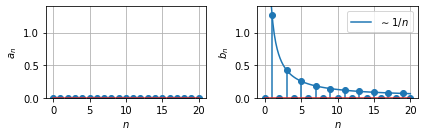

In [6]:
t_period = np.arange(0, 1, 1/Fs)
F = fourierSeries(func1(t_period), 20)
plt.figure(figsize=(6,2))
plt.subplot(121); plt.stem(F[:,0])
plt.grid(True); plt.xlabel('$n$'); plt.ylabel('$a_n$'); plt.ylim((0,1.4))
plt.subplot(122); plt.stem(F[:,1])
plt.grid(True); plt.xlabel('$n$'); plt.ylabel('$b_n$'); plt.ylim((0,1.4))
n = np.linspace(0.1,20,100);plt.plot(n, 4/(np.pi*n), label=r'$\sim 1/n$'); plt.legend(fontsize=10)
plt.tight_layout()

We make two observations here: First, we see that $a_n=0$. From the plot for function 1 we see that it is an odd function, i.e. $x(t)=-x(-t)$. In this case, the Fourier series only contains odd functions, which are solely the terms including the sines (since $\sin(x)=-\sin(-x)$). Second, the Fourier coefficients $b_n$ decay slowly with speed $1/n$ and every 2nd $b_n$ is zero. We can explain this by relating it to knowledge of the [Fourier Transform](http://dspillustrations.com/pages/posts/misc/approximating-the-fourier-transform-with-dft.html): The function is a sum of two rectangular functions of width $\frac{1}{2}s$. We know the Fourier transform of such a rectangle is a sinc-function, which has zeros at a distance of $2Hz$. Furthermore, the magnitude of the sinc-function decays with $1/f$. This is very in line with the obtained coefficients: They decay with $1/n$ and every 2nd values is zero.

Let us now look at the reconstruction of the signal, i.e. we calculate $x(t)$ from its Fourier series coefficients up to a given order. We write a function `reconstruct` to do this for us:

In [7]:
def reconstruct(P, anbn):
    result = 0
    t = np.arange(P)
    for n, (a, b) in enumerate(anbn):
        if n == 0:
            a = a/2
        result = result + a*np.cos(2*np.pi*n*t/P) + b * np.sin(2*np.pi*n*t/P)
    return result

Let's have a look at the reconstructed signal for our rectangular function up to the 20th harmonic:

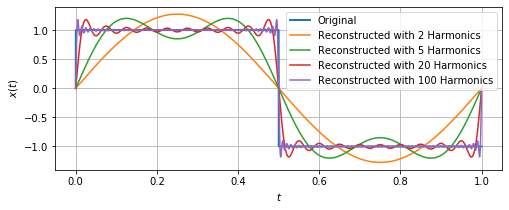

In [8]:
F = fourierSeries(func1(t_period), 100)
plt.plot(t_period, func1(t_period), label='Original', lw=2)
plt.plot(t_period, reconstruct(len(t_period), F[:2,:]), label='Reconstructed with 2 Harmonics');
plt.plot(t_period, reconstruct(len(t_period), F[:5,:]), label='Reconstructed with 5 Harmonics');
plt.plot(t_period, reconstruct(len(t_period), F[:20,:]), label='Reconstructed with 20 Harmonics');
plt.plot(t_period, reconstruct(len(t_period), F[:100,:]), label='Reconstructed with 100 Harmonics');
plt.grid(True); plt.ylabel('$x(t)$'); plt.xlabel('$t$');
plt.legend(fontsize=10);

As we can see, the reconstructed signal roughly follows the original, and the more harmonics are used, the better. However, we also see that especially in the region of the jump at $t=0.5$, the reconstructed signal is not exact. Instead, the reconstructed signal significantly fluctuates at this position. This phenomenom is called [Gibbs Phenonenom](https://en.wikipedia.org/wiki/Gibbs_phenomenon "Wikipedia Link") and describes the fact that the Fourier series has large oscillations around jump discontinuities. In particular, the height of overshooting or undershooting does not depend on the number of harmonics and is roughly 9% of the jump height. However, the duration of the oscillations decreases with the number of harmonics, eventually leading to a correct approximation in the limit for infinitely many harmonics. 

Let us now have a look at the Fourier Series of some functions, and how their approximation by the Fourier series appears for different number of Harmonics:

In [9]:
def showHarmonics(period, N):
    """Calculate the Fourier Series up to N harmonics, and show the reconstructed signal."""
    F = fourierSeries(period, N+1)
    plt.gcf().clear()
    plt.subplot(231); plt.stem(F[:,0])
    plt.xlim((0,20)); Vi = F.min(); Va = F.max(); plt.ylim((Vi,Va)); plt.ylabel('$a_n$')
    plt.subplot(234); plt.stem(F[:,1])
    plt.xlim((0,20)); plt.ylim((Vi,Va)); plt.xlabel('Harmonic'); plt.ylabel('$b_n$')
    plt.subplot(132)
    T = len(period)
    t = np.arange(T)/T
    result = 0
    for n, (an, bn) in enumerate(F):
        if n == 0:
            an = an/2
        cos_part = an*np.cos(2*np.pi*n*t)
        sin_part = bn*np.sin(2*np.pi*n*t)
        plt.plot(t, cos_part)
        plt.plot(t, sin_part)
        result = result + cos_part + sin_part
    plt.grid(True); plt.ylabel(r'$a_n \sin(2\pi n t), b_n\cos(2\pi nt)$'); plt.xlabel('$t$');
    plt.text(0.5, 0.8*abs(F[1:,:]).max(), 'N=%d' % N, bbox=dict(facecolor='white'))
    plt.subplot(133)
    t2 = np.arange(2*T)/T
    plt.plot(t2, np.tile(period, 2))
    plt.plot(t2, np.tile(result, 2))
    plt.grid(True); plt.ylabel(r'$x(t), r_N(t)$'); plt.xlabel('$t$');
    plt.ylim((period.min()-0.4, period.max()+0.4))
    plt.tight_layout()
    showInInteract()

First, we again see the rectangular function. With increasing number of harmonics, we see that the rect is approximated better. However, we also see that the amount of overshooting at the jump discontinuity stays constant, independent of the number of harmonics.

In [13]:
period = func1(np.arange(0, 1, 1/Fs))
interact(lambda N: showHarmonics(period, N), N=(1, 20));

interactive(children=(IntSlider(value=10, description='N', max=20, min=1), Output()), _dom_classes=('widget-in…

Next is the periodic linear ramp function. Again, we see that the amount of overshooting at the discontinuity is independent of the number of harmonics. However, the duration of the oscillations becomes shorter and in general the approximation becomes better with more harmonics. Also, except for the DC component $a_0$, all coefficients $a_n=0$. This is again due to the fact that the function is odd, i.e. we have $x(t)=1-x(-t)$. Therefore, only the components for the sine-wave are non-zero. 

In [24]:
period = func2(np.arange(0, 1, 1/Fs))
interact(lambda N: showHarmonics(period, N), N=(1, 20));

interactive(children=(IntSlider(value=10, description='N', max=20, min=1), Output()), _dom_classes=('widget-in…

The third function looks more complicated since it has more jumps and is in general more irregular than the previous functions. In fact, there is a significant amount of overshooting in the lower part of the graph, which only very slowly decreases with more harmonics. This is coming from the high amount of discontinuities of the function. The function is an even function, i.e. $x(t)=x(-t)$. Therefore, all $b_n=0$, which correspond to the contribution of the sine-waves. Instead, only the cosine-waves, which are even functions, make up the overall Fourier series. 

In [25]:
period = func3(np.arange(0, 1, 1/Fs))
interact(lambda N: showHarmonics(period, N), N=(1, 20));

interactive(children=(IntSlider(value=10, description='N', max=20, min=1), Output()), _dom_classes=('widget-in…

Eventually, we take a look at the periodic parabola function. First, we recognize that the function is well approximated with only very few harmonics. We can explain this by the general smoothness of the function with no discontinuities. Additionally, we again identify that $b_n=0$, since $x(t)$ is an even function, i.e. $x(t)=x(-t)$.

In [26]:
period = func4(np.arange(0, 1, 1/Fs))
interact(lambda N: showHarmonics(period, N), N=(1, 20));

interactive(children=(IntSlider(value=10, description='N', max=20, min=1), Output()), _dom_classes=('widget-in…

## Summary
> - The Fourier Series decomposes a periodic function with period T into sines and cosines with frequencies $\frac{n}{T}, n=0,1,2,\ldots$ which are called the $n$th harmonics of the signal. The more harmonics are used, the more accurate can a function be described.
> - For **even functions**, i.e. $x(t)=x(-t)$, the Fourier series **only consists of cosines**. For **odd functions**, i.e. $x(t)=-x(-t)$, the Fourier series **only consists of sines**.
> - At jump discontinuities, the value of the Fourier series is in the middle of the jump. Around the jump, overshooting of the series occurs, which is called **Gibbs Phenonemon**. The amount of overshooting does not reduce with the number of harmonics, but the duration reduces.
> - Smooth functions need less harmonics to be accurately described by the Fourier series.

In a future article, we will investigate the relation of the Fourier series to the Fourier transform, and analyze sounds of instruments according to their structure of the harmonics. Subscribe to our newsletter on the right to not miss upcoming posts!